In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-simpsons-characters-dataset/weights.best.hdf5
/kaggle/input/the-simpsons-characters-dataset/annotation.txt
/kaggle/input/the-simpsons-characters-dataset/number_pic_char.csv
/kaggle/input/the-simpsons-characters-dataset/characters_illustration.png
/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/milhouse_van_houten_28.jpg
/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/apu_nahasapeemapetilon_42.jpg
/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/krusty_the_clown_6.jpg
/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/lenny_leonard_22.jpg
/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/marge_simpson_16.jpg
/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/chief_wiggum_41.jpg
/kaggle/input/the-simpsons-characters-dat

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt 
import os
import tensorflow as tf
import cv2
from tensorflow.keras.callbacks import EarlyStopping
import glob
from tensorflow.keras.optimizers import Lion

%matplotlib inline

import warnings 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Çok fazla çakışma sebepli warning aldığım için görsellik açısından ignore attım
warnings.filterwarnings("ignore")

In [4]:
!pip install split-folders

In [5]:
import splitfolders

input_dir="/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset"
output_dir="./data"

splitfolders.ratio(input_dir, output_dir, seed=1337, ratio=(.9, .1))

Copying files: 20933 files [02:16, 152.92 files/s]


In [6]:
train_dir = "./data/train"
val_dir = "./data/val"
test_dir = "./data/test"

image_size = (64, 64, 3)

epochs = 75

batch_size = 100 

labels = os.listdir(train_dir)

---------------------------------------------
./data/train/lisa_simpson/pic_0001.jpg
---------------------------------------------


---------------------------------------------
./data/train/fat_tony/pic_0003.jpg
---------------------------------------------


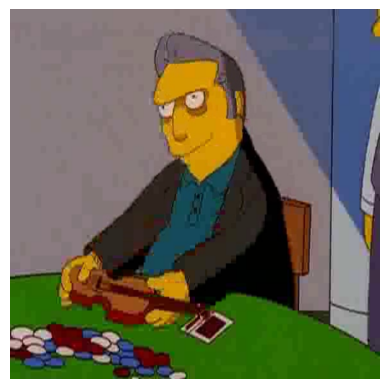

---------------------------------------------
./data/train/abraham_grampa_simpson/pic_0006.jpg
---------------------------------------------


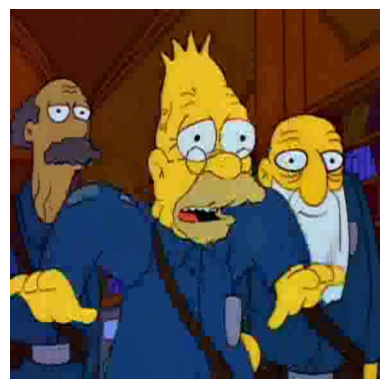

In [7]:
def plot(image_location):
    image = cv2.imread(image_location)
    image = cv2.resize(image, (512, 512))
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

image_name = train_dir + "/lisa_simpson/pic_0001.jpg"
print("---------------------------------------------")
print(image_name)
print("---------------------------------------------")
plot(image_name)
image_name2 = train_dir + "/fat_tony/pic_0003.jpg"
print("---------------------------------------------")
print(image_name2)
print("---------------------------------------------")
plot(image_name2)
print("---------------------------------------------")
image_name3 = train_dir + "/abraham_grampa_simpson/pic_0006.jpg"
print(image_name3)
print("---------------------------------------------")
plot(image_name3)

| Parametre                  | Açıklama                                                          |
|----------------------------|-------------------------------------------------------------------|
| `rescale=1./255`           | Piksel değerlerini 255'e bölerek 0-1 arasına çekiyorum                             |
| `rotation_range=30`        | Rastgele döndürme işlemi uyguluyorum. Görüntüyü 30 derece rastgele döndürür.                                    |
| `zoom_range=.15`           | Rastgele yakınlaştırma işlemi uyguluyorum. Görüntüyü %15 yaklaştırır.                                                   |
| `shear_range=.15`          | Rastgele şekil bozma işlemi uyguluyorum. Görüntülerin %15 boyutunda rastgele bükülmesini sağlar.                                                                |
| `width_shift_range=.2`     | Görüntüleri yatay yönde rastgele kaydırıyorum. Görüntüler rastgele şekilde %20 boyutunda yatayda kayar.                                     |
| `height_shift_range=.2`    | Görüntüleri dikey yönde rastgele kaydırıyorum. Görüntüler rastgele şekilde %20 boyutunda dikeyde kayar                                  |
| `vertical_flip=True`       | Rastgele dikey simetri işlemi uyguluyorum. Görüntüleri rastgele bir şekilde dikey olarak çevirir.                                               |


In [8]:
train_data_gen= ImageDataGenerator(rescale=1./255,
                            rotation_range=30,
                            zoom_range=.15,
                            shear_range=.15,
                            width_shift_range=.2,
                            height_shift_range=.2,
                            vertical_flip=True,
                            )

test_data_gen = ImageDataGenerator(rescale=1./255) # Test datasına veri arttırmama gerek yok.

In [9]:
training_set =  train_data_gen.flow_from_directory(
                                                    train_dir,
                                                    target_size=image_size[:2], # Renk kanalları hariç
                                                    batch_size=batch_size,
                                                    class_mode='categorical', # Çok sınıflı problem
                                                    color_mode='rgb'# Renkli

)

val_set =  test_data_gen.flow_from_directory(
                                                    val_dir,
                                                    target_size=image_size[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb'

)

Found 18820 images belonging to 43 classes.
Found 2113 images belonging to 43 classes.


|                   | Sınıf Sayısı | Toplam Görüntü Sayısı |
|-------------------|--------------|-----------------------|
| **Eğitim Seti**   |      43      |        18,820        |
| **Doğrulama Seti** |      43      |         2,113        |

In [10]:
for data_batch, labels_batch in training_set:
    print(data_batch.shape)
    break

(100, 64, 64, 3)


In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=image_size, activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.3)) 

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), padding='same', activation="relu")) 
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())  
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        36928     
                                                        

In [13]:
from tensorflow.keras.optimizers import Lion
lion = Lion()

In [14]:
model.compile(loss='categorical_crossentropy', optimizer = lion  ,metrics=['accuracy'])

In [15]:
checkpoint_filepath = "./model.h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [
             EarlyStopping(patience=5, monitor="val_accuracy", mode="max"),
             model_checkpoint_callback,
]


In [16]:
history = model.fit_generator(  training_set,
                                epochs=epochs,
                                validation_data=val_set,
                                callbacks = callbacks
)

Epoch 1/75


2023-12-29 12:55:31.647316: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


189/189 [==============================] - 60s 256ms/step - loss: 3.2034 - accuracy: 0.0912 - val_loss: 3.1362 - val_accuracy: 0.1065
Epoch 2/75
189/189 [==============================] - 47s 251ms/step - loss: 3.1194 - accuracy: 0.1036 - val_loss: 3.1038 - val_accuracy: 0.1065
Epoch 3/75
189/189 [==============================] - 47s 250ms/step - loss: 3.0590 - accuracy: 0.1077 - val_loss: 3.0273 - val_accuracy: 0.1126
Epoch 4/75
189/189 [==============================] - 47s 248ms/step - loss: 2.9955 - accuracy: 0.1232 - val_loss: 2.9367 - val_accuracy: 0.1335
Epoch 5/75
189/189 [==============================] - 48s 252ms/step - loss: 2.9482 - accuracy: 0.1294 - val_loss: 2.8754 - val_accuracy: 0.1382
Epoch 6/75
189/189 [==============================] - 47s 247ms/step - loss: 2.8982 - accuracy: 0.1423 - val_loss: 2.8144 - val_accuracy: 0.1609
Epoch 7/75
189/189 [==============================] - 48s 252ms/step - loss: 2.8160 - accuracy: 0.1701 - val_loss: 2.6674 - val_accuracy: 0.2

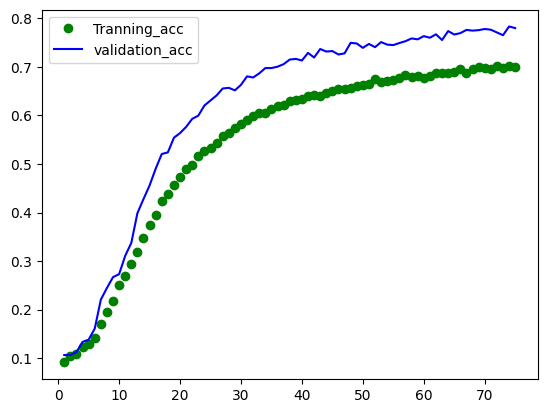

In [17]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Tranning_acc", color = "green")
plt.plot(epochs, val_acc, "b", label="validation_acc", color = "blue")
plt.legend()
plt.show()

In [18]:
image_size = (224,224, 3)
epochs = 20

In [19]:
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow.keras.optimizers.legacy

In [20]:
sgd=tf.keras.optimizers.legacy.SGD()

In [21]:
model=Sequential()
model.add(ResNet50(include_top=False,
               pooling='max'))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))

94765736/94765736 [==============================] - 0s 0us/step


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 43)                44075     
                                                                 
Total params: 25729963 (98.15 MB)
Trainable params: 25676843 (97.95 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [23]:
model.compile(loss='categorical_crossentropy',optimizer = sgd  ,metrics=['accuracy'])

In [24]:
history = model.fit_generator(  training_set,
                                epochs=epochs,
                                validation_data=val_set,
                                callbacks = callbacks
)

Epoch 1/20
189/189 [==============================] - 58s 269ms/step - loss: 3.6318 - accuracy: 0.1927 - val_loss: 238.9099 - val_accuracy: 0.1065
Epoch 2/20
189/189 [==============================] - 48s 256ms/step - loss: 2.2816 - accuracy: 0.4190 - val_loss: 3.4746 - val_accuracy: 0.0663
Epoch 3/20
189/189 [==============================] - 47s 250ms/step - loss: 1.7797 - accuracy: 0.5396 - val_loss: 3.4906 - val_accuracy: 0.1008
Epoch 4/20
189/189 [==============================] - 48s 255ms/step - loss: 1.5325 - accuracy: 0.5992 - val_loss: 3.1130 - val_accuracy: 0.1789
Epoch 5/20
189/189 [==============================] - 48s 255ms/step - loss: 1.3607 - accuracy: 0.6443 - val_loss: 1.7215 - val_accuracy: 0.5343
Epoch 6/20
189/189 [==============================] - 49s 257ms/step - loss: 1.2416 - accuracy: 0.6736 - val_loss: 1.1321 - val_accuracy: 0.6952
Epoch 7/20
189/189 [==============================] - 48s 251ms/step - loss: 1.1140 - accuracy: 0.7017 - val_loss: 0.9089 - val_

In [25]:
plt.plot(history.history['accuracy'], label='Traning accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

In [26]:
plt.plot(history.history['loss'], label='Traning loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()